In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

In [3]:
!pip install torchsummary
!pip install thop

# Model Design


Some tips you can use in the model design:

*   Convolution
*   Linear
*   Pooling
*   Batch normalization
*   ReLU
*   Dropout




In [8]:
import torch
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self, in_size=(1, 28, 28), num_classes=10):
        super().__init__()
        ### TODO : You can design the model architechture ###
        self.conv1 = self.__make_layer(in_size[0], 32)
        self.conv2 = self.__make_layer(32, 64)
        self.conv3 = self.__make_layer(64, 128)
        self.fc = nn.Sequential(
            nn.Linear(128 * ((in_size[1] // 8) * (in_size[2] // 8)), 256),
            nn.ReLU(True),
            nn.Linear(256, num_classes),
        )

    def __make_layer(self, in_channels, out_channels):
       return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = torch.flatten(x, start_dim=1)
      x = self.fc(x)
      return x

In [3]:
# Create an instance of the DNN model
net1 = DNN(in_size=(1, 28, 28), num_classes=10).to(device)
net2 = DNN(in_size=(1, 28, 28), num_classes=10).to(device)
net3 = DNN(in_size=(1, 28, 28), num_classes=10).to(device)

In [4]:
net1

DNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1

# Caculating the number of the parameter and the MACs of the model

In [5]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# grad_para = count_parameters(net1)
# print(f'Total params: {grad_para / 1e6}M')
# summary(net1.to('cuda:0'), (1, 28, 28))

#Compute MACs
from thop import profile
input1 = torch.randn(1, 1, 28, 28).to(device)
MACs, params = profile(net1.to(device), inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MACs = 0.007924224G
Params = 0.390634M


# Configuration

In [6]:
### TODO : You can modify the configuration for model training ###
config1 = {
    'name': 'basic',
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optim.SGD(net1.parameters(), lr=0.001, momentum=0.9),
    'batch_size': 512,
    'patience': 5,
    'n_epoch': 40,
}

config2 = {
    'name': 'adam',
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optim.Adam(net2.parameters(), lr=0.001),
    'batch_size': config1['batch_size'],
    'patience': config1['patience'],
    'n_epoch': config1['n_epoch'],
}

config3 = {
    'name': 'augment',
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optim.SGD(net3.parameters(), lr=0.001, momentum=0.9),
    'batch_size': config1['batch_size'],
    'patience': config1['patience'],
    'n_epoch': config1['n_epoch'],
}

# Dataloader

In [1]:
def prepare_data(config, dataset_souce, transform_train):
    # Select training_set and testing_set
    trainset = dataset_souce("data", train=True, download=True, transform=transform_train)
    testset = dataset_souce("data", train=False, download=True, transform=transforms.ToTensor())

    # # Number of subprocesses to use for data loading
    num_workers = 2

    # Percentage of training set to use as validation
    n_valid = 0.2

    # Get indices for training_set and validation_set
    n_train = len(trainset)
    indices = list(range(n_train))
    np.random.shuffle(indices)

    split = int(np.floor(n_valid * n_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # Define samplers for obtaining training and validation
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Dataloaders for training, validation, and testing data
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],  sampler=train_sampler, num_workers=num_workers)
    validloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'], sampler=valid_sampler, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=config['batch_size'],  num_workers=num_workers)
    return {'train': trainloader, 'valid': validloader, 'test': testloader}

# Labels
classes = ("T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot")

In [9]:
# basic
dataloaders1 = prepare_data(config1, datasets.FashionMNIST, transforms.ToTensor())

# adam
dataloaders2 = prepare_data(config2, datasets.FashionMNIST, transforms.ToTensor())

# augment
dataloaders3 = prepare_data(config3, datasets.FashionMNIST, transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),]))

# Model Training

In [12]:
def train_model(net: torch.nn.Module, config: dict, dataloaders: dict, device: torch.DeviceObjType):
    trainloader = dataloaders['train']
    validloader = dataloaders['valid']

    train_loss_epoch = []
    train_acc_epoch = []
    val_loss_epoch = []
    val_acc_epoch = []
    best_acc = 0
    epoch_counter = 0

    for epoch in range(config['n_epoch']):  # loop over the dataset multiple times


        running_loss = 0.0
        epoch_counter += 1

        ################## Training ##################
        # These are used to record information in training.
        train_loss = []
        train_accs = []

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if use_gpu:
                inputs, labels = inputs.to(device),labels.to(device)
            # zero the parameter gradients
            config['optimizer'].zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = config['criterion'](outputs, labels)
            loss.backward()
            config['optimizer'].step()

            # Compute the accuracy for current batch.
            acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        train_loss_epoch.append(train_loss)
        train_acc_epoch.append(train_acc)

        # Print the information.
        print('========================================================================================================')
        print(f"[ Train | {epoch + 1:03d}/{config['n_epoch']:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        ################## Validition ##################
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for data in tqdm(validloader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = data
            #imgs = imgs.half()

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = net(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = config['criterion'](logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)
            #break

        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        val_loss_epoch.append(valid_loss)


        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{config['n_epoch']:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


        # save models
        if valid_acc > best_acc:
            print(f"Best model found at epoch {epoch}, saving model")
            torch.save(net.state_dict(), f"{config['name']}_best.ckpt") # only save best to prevent output memory exceed error
            best_acc = valid_acc
            stale = 0
        else:
            stale += 1
            if stale > config['patience']:
                print(f"No improvment {config['patience']} consecutive epochs, early stopping")
                break

    print('Finished Training')
    return {
        'train_loss': train_loss_epoch,
        'train_acc': train_acc_epoch,
        'val_loss': val_loss_epoch,
        'val_acc': val_acc_epoch,
    }

In [13]:
results1 = train_model(net1, config1, dataloaders1, device)

[ Train | 001/040 ] loss = 1.40594, acc = 0.60495


100%|██████████| 24/24 [00:01<00:00, 22.44it/s]

[ Valid | 001/040 ] loss = 0.80738, acc = 0.74977
Best model found at epoch 0, saving model


[ Train | 002/040 ] loss = 0.68140, acc = 0.77278


100%|██████████| 24/24 [00:01<00:00, 22.63it/s]

[ Valid | 002/040 ] loss = 0.61013, acc = 0.78682
Best model found at epoch 1, saving model


[ Train | 003/040 ] loss = 0.55759, acc = 0.80725


100%|██████████| 24/24 [00:00<00:00, 24.73it/s]


[ Valid | 003/040 ] loss = 0.52474, acc = 0.81748
Best model found at epoch 2, saving model
[ Train | 004/040 ] loss = 0.49021, acc = 0.83081


100%|██████████| 24/24 [00:01<00:00, 19.47it/s]

[ Valid | 004/040 ] loss = 0.47427, acc = 0.83474
Best model found at epoch 3, saving model


[ Train | 005/040 ] loss = 0.44460, acc = 0.84780


100%|██████████| 24/24 [00:01<00:00, 14.01it/s]

[ Valid | 005/040 ] loss = 0.43395, acc = 0.84797
Best model found at epoch 4, saving model


[ Train | 006/040 ] loss = 0.40929, acc = 0.85966


100%|██████████| 24/24 [00:01<00:00, 23.70it/s]

[ Valid | 006/040 ] loss = 0.40173, acc = 0.85899
Best model found at epoch 5, saving model


[ Train | 007/040 ] loss = 0.38245, acc = 0.86822


100%|██████████| 24/24 [00:01<00:00, 21.31it/s]

[ Valid | 007/040 ] loss = 0.38067, acc = 0.86587
Best model found at epoch 6, saving model


[ Train | 008/040 ] loss = 0.36128, acc = 0.87357


100%|██████████| 24/24 [00:00<00:00, 24.66it/s]


[ Valid | 008/040 ] loss = 0.36626, acc = 0.87257
Best model found at epoch 7, saving model
[ Train | 009/040 ] loss = 0.34353, acc = 0.88004


100%|██████████| 24/24 [00:00<00:00, 24.29it/s]

[ Valid | 009/040 ] loss = 0.34675, acc = 0.87860
Best model found at epoch 8, saving model


[ Train | 010/040 ] loss = 0.32902, acc = 0.88441


100%|██████████| 24/24 [00:00<00:00, 26.84it/s]

[ Valid | 010/040 ] loss = 0.33386, acc = 0.88221
Best model found at epoch 9, saving model


[ Train | 011/040 ] loss = 0.31582, acc = 0.88898


100%|██████████| 24/24 [00:01<00:00, 23.29it/s]

[ Valid | 011/040 ] loss = 0.32432, acc = 0.88499
Best model found at epoch 10, saving model


[ Train | 012/040 ] loss = 0.30405, acc = 0.89274


100%|██████████| 24/24 [00:01<00:00, 20.05it/s]

[ Valid | 012/040 ] loss = 0.31652, acc = 0.88785
Best model found at epoch 11, saving model


[ Train | 013/040 ] loss = 0.29443, acc = 0.89650


100%|██████████| 24/24 [00:01<00:00, 18.55it/s]

[ Valid | 013/040 ] loss = 0.30655, acc = 0.89224
Best model found at epoch 12, saving model


[ Train | 014/040 ] loss = 0.28538, acc = 0.89903


100%|██████████| 24/24 [00:01<00:00, 23.54it/s]

[ Valid | 014/040 ] loss = 0.30153, acc = 0.89268
Best model found at epoch 13, saving model


[ Train | 015/040 ] loss = 0.27734, acc = 0.90231


100%|██████████| 24/24 [00:01<00:00, 21.49it/s]

[ Valid | 015/040 ] loss = 0.29616, acc = 0.89523
Best model found at epoch 14, saving model


[ Train | 016/040 ] loss = 0.27016, acc = 0.90458


100%|██████████| 24/24 [00:01<00:00, 22.83it/s]

[ Valid | 016/040 ] loss = 0.29328, acc = 0.89622
Best model found at epoch 15, saving model


[ Train | 017/040 ] loss = 0.26292, acc = 0.90644


100%|██████████| 24/24 [00:01<00:00, 20.53it/s]

[ Valid | 017/040 ] loss = 0.28488, acc = 0.89965
Best model found at epoch 16, saving model


[ Train | 018/040 ] loss = 0.25538, acc = 0.91086


100%|██████████| 24/24 [00:01<00:00, 21.32it/s]


[ Valid | 018/040 ] loss = 0.28589, acc = 0.90003
Best model found at epoch 17, saving model
[ Train | 019/040 ] loss = 0.24921, acc = 0.91284


100%|██████████| 24/24 [00:01<00:00, 22.40it/s]

[ Valid | 019/040 ] loss = 0.28317, acc = 0.89830


[ Train | 020/040 ] loss = 0.24392, acc = 0.91372


100%|██████████| 24/24 [00:01<00:00, 23.41it/s]


[ Valid | 020/040 ] loss = 0.27159, acc = 0.90339
Best model found at epoch 19, saving model
[ Train | 021/040 ] loss = 0.23705, acc = 0.91714


100%|██████████| 24/24 [00:01<00:00, 16.73it/s]

[ Valid | 021/040 ] loss = 0.27018, acc = 0.90252


[ Train | 022/040 ] loss = 0.23192, acc = 0.91836


100%|██████████| 24/24 [00:01<00:00, 23.99it/s]

[ Valid | 022/040 ] loss = 0.26707, acc = 0.90411
Best model found at epoch 21, saving model


[ Train | 023/040 ] loss = 0.22670, acc = 0.92073


100%|██████████| 24/24 [00:01<00:00, 23.49it/s]

[ Valid | 023/040 ] loss = 0.26576, acc = 0.90435
Best model found at epoch 22, saving model


[ Train | 024/040 ] loss = 0.22278, acc = 0.92227


100%|██████████| 24/24 [00:01<00:00, 19.87it/s]

[ Valid | 024/040 ] loss = 0.26058, acc = 0.90663
Best model found at epoch 23, saving model


[ Train | 025/040 ] loss = 0.21626, acc = 0.92465


100%|██████████| 24/24 [00:01<00:00, 20.06it/s]

[ Valid | 025/040 ] loss = 0.26160, acc = 0.90739
Best model found at epoch 24, saving model


[ Train | 026/040 ] loss = 0.21187, acc = 0.92676


100%|██████████| 24/24 [00:00<00:00, 24.03it/s]

[ Valid | 026/040 ] loss = 0.25729, acc = 0.90930
Best model found at epoch 25, saving model


[ Train | 027/040 ] loss = 0.20821, acc = 0.92763


100%|██████████| 24/24 [00:01<00:00, 22.76it/s]

[ Valid | 027/040 ] loss = 0.25854, acc = 0.90733


[ Train | 028/040 ] loss = 0.20289, acc = 0.93008


100%|██████████| 24/24 [00:01<00:00, 21.14it/s]

[ Valid | 028/040 ] loss = 0.25402, acc = 0.90795


[ Train | 029/040 ] loss = 0.19917, acc = 0.93162


100%|██████████| 24/24 [00:01<00:00, 23.87it/s]

[ Valid | 029/040 ] loss = 0.25633, acc = 0.90746


[ Train | 030/040 ] loss = 0.19467, acc = 0.93330


100%|██████████| 24/24 [00:01<00:00, 20.97it/s]

[ Valid | 030/040 ] loss = 0.25147, acc = 0.91039
Best model found at epoch 29, saving model


[ Train | 031/040 ] loss = 0.19112, acc = 0.93379


100%|██████████| 24/24 [00:01<00:00, 19.84it/s]

[ Valid | 031/040 ] loss = 0.25079, acc = 0.90964


[ Train | 032/040 ] loss = 0.18744, acc = 0.93674


100%|██████████| 24/24 [00:01<00:00, 14.81it/s]

[ Valid | 032/040 ] loss = 0.25327, acc = 0.91011


[ Train | 033/040 ] loss = 0.18147, acc = 0.93887


100%|██████████| 24/24 [00:01<00:00, 19.32it/s]

[ Valid | 033/040 ] loss = 0.25067, acc = 0.91220
Best model found at epoch 32, saving model


[ Train | 034/040 ] loss = 0.17975, acc = 0.93868


100%|██████████| 24/24 [00:01<00:00, 21.95it/s]

[ Valid | 034/040 ] loss = 0.25980, acc = 0.90630


[ Train | 035/040 ] loss = 0.17540, acc = 0.94080


100%|██████████| 24/24 [00:01<00:00, 18.08it/s]

[ Valid | 035/040 ] loss = 0.24533, acc = 0.91209


[ Train | 036/040 ] loss = 0.17033, acc = 0.94359


100%|██████████| 24/24 [00:01<00:00, 20.70it/s]

[ Valid | 036/040 ] loss = 0.24614, acc = 0.91013


[ Train | 037/040 ] loss = 0.16641, acc = 0.94452


100%|██████████| 24/24 [00:01<00:00, 21.94it/s]

[ Valid | 037/040 ] loss = 0.24845, acc = 0.91026


[ Train | 038/040 ] loss = 0.16441, acc = 0.94495


100%|██████████| 24/24 [00:01<00:00, 22.72it/s]

[ Valid | 038/040 ] loss = 0.24343, acc = 0.91341
Best model found at epoch 37, saving model


[ Train | 039/040 ] loss = 0.15950, acc = 0.94706


100%|██████████| 24/24 [00:01<00:00, 21.88it/s]

[ Valid | 039/040 ] loss = 0.24103, acc = 0.91289


[ Train | 040/040 ] loss = 0.15571, acc = 0.94862


100%|██████████| 24/24 [00:01<00:00, 15.96it/s]

[ Valid | 040/040 ] loss = 0.24602, acc = 0.91063
Finished Training


In [14]:
results2 = train_model(net2, config2, dataloaders2, device)

[ Train | 001/040 ] loss = 0.50288, acc = 0.81947


100%|██████████| 24/24 [00:01<00:00, 22.43it/s]

[ Valid | 001/040 ] loss = 0.31079, acc = 0.89080
Best model found at epoch 0, saving model


[ Train | 002/040 ] loss = 0.28738, acc = 0.89596


100%|██████████| 24/24 [00:01<00:00, 22.55it/s]

[ Valid | 002/040 ] loss = 0.27987, acc = 0.89780
Best model found at epoch 1, saving model


[ Train | 003/040 ] loss = 0.24613, acc = 0.91055


100%|██████████| 24/24 [00:01<00:00, 16.57it/s]

[ Valid | 003/040 ] loss = 0.25249, acc = 0.91084
Best model found at epoch 2, saving model


[ Train | 004/040 ] loss = 0.21838, acc = 0.92071


100%|██████████| 24/24 [00:01<00:00, 21.79it/s]

[ Valid | 004/040 ] loss = 0.23689, acc = 0.91499
Best model found at epoch 3, saving model


[ Train | 005/040 ] loss = 0.18008, acc = 0.93546


100%|██████████| 24/24 [00:01<00:00, 22.89it/s]

[ Valid | 005/040 ] loss = 0.22465, acc = 0.92078
Best model found at epoch 4, saving model


[ Train | 006/040 ] loss = 0.16318, acc = 0.94080


100%|██████████| 24/24 [00:01<00:00, 19.29it/s]

[ Valid | 006/040 ] loss = 0.24567, acc = 0.91159


[ Train | 007/040 ] loss = 0.14280, acc = 0.94821


100%|██████████| 24/24 [00:01<00:00, 19.98it/s]

[ Valid | 007/040 ] loss = 0.22568, acc = 0.92143
Best model found at epoch 6, saving model


[ Train | 008/040 ] loss = 0.11893, acc = 0.95717


100%|██████████| 24/24 [00:01<00:00, 21.65it/s]

[ Valid | 008/040 ] loss = 0.24721, acc = 0.91567


[ Train | 009/040 ] loss = 0.10899, acc = 0.96092


100%|██████████| 24/24 [00:01<00:00, 21.68it/s]

[ Valid | 009/040 ] loss = 0.22627, acc = 0.92365
Best model found at epoch 8, saving model


[ Train | 010/040 ] loss = 0.09371, acc = 0.96627


100%|██████████| 24/24 [00:01<00:00, 19.24it/s]

[ Valid | 010/040 ] loss = 0.27017, acc = 0.91132


[ Train | 011/040 ] loss = 0.09279, acc = 0.96644


100%|██████████| 24/24 [00:01<00:00, 18.01it/s]

[ Valid | 011/040 ] loss = 0.24818, acc = 0.92084


[ Train | 012/040 ] loss = 0.06352, acc = 0.97809


100%|██████████| 24/24 [00:01<00:00, 23.95it/s]

[ Valid | 012/040 ] loss = 0.26653, acc = 0.92239


[ Train | 013/040 ] loss = 0.05814, acc = 0.97972


100%|██████████| 24/24 [00:01<00:00, 21.23it/s]

[ Valid | 013/040 ] loss = 0.25751, acc = 0.92476
Best model found at epoch 12, saving model


[ Train | 014/040 ] loss = 0.04818, acc = 0.98334


100%|██████████| 24/24 [00:01<00:00, 20.36it/s]

[ Valid | 014/040 ] loss = 0.27008, acc = 0.92414


[ Train | 015/040 ] loss = 0.04141, acc = 0.98579


100%|██████████| 24/24 [00:01<00:00, 18.70it/s]

[ Valid | 015/040 ] loss = 0.30204, acc = 0.91696


[ Train | 016/040 ] loss = 0.04549, acc = 0.98354


100%|██████████| 24/24 [00:00<00:00, 24.18it/s]

[ Valid | 016/040 ] loss = 0.29957, acc = 0.92039


[ Train | 017/040 ] loss = 0.02668, acc = 0.99195


100%|██████████| 24/24 [00:01<00:00, 20.28it/s]

[ Valid | 017/040 ] loss = 0.31721, acc = 0.92207


[ Train | 018/040 ] loss = 0.02508, acc = 0.99199


100%|██████████| 24/24 [00:01<00:00, 18.73it/s]

[ Valid | 018/040 ] loss = 0.34332, acc = 0.91507


[ Train | 019/040 ] loss = 0.03008, acc = 0.98939


100%|██████████| 24/24 [00:01<00:00, 13.69it/s]

[ Valid | 019/040 ] loss = 0.34925, acc = 0.91371
No improvment 5 consecutive epochs, early stopping
Finished Training


In [15]:
results3 = train_model(net3, config3, dataloaders3, device)

[ Train | 001/040 ] loss = 1.52416, acc = 0.56503


100%|██████████| 24/24 [00:02<00:00, 10.49it/s]

[ Valid | 001/040 ] loss = 1.02642, acc = 0.69119
Best model found at epoch 0, saving model


[ Train | 002/040 ] loss = 0.87736, acc = 0.71675


100%|██████████| 24/24 [00:02<00:00,  9.60it/s]

[ Valid | 002/040 ] loss = 0.78838, acc = 0.72872
Best model found at epoch 1, saving model


[ Train | 003/040 ] loss = 0.72820, acc = 0.74278


100%|██████████| 24/24 [00:02<00:00,  9.95it/s]

[ Valid | 003/040 ] loss = 0.68849, acc = 0.74979
Best model found at epoch 2, saving model


[ Train | 004/040 ] loss = 0.65815, acc = 0.76221


100%|██████████| 24/24 [00:02<00:00,  8.64it/s]

[ Valid | 004/040 ] loss = 0.63271, acc = 0.76914
Best model found at epoch 3, saving model


[ Train | 005/040 ] loss = 0.61255, acc = 0.77841


100%|██████████| 24/24 [00:02<00:00, 10.58it/s]

[ Valid | 005/040 ] loss = 0.59304, acc = 0.77984
Best model found at epoch 4, saving model


[ Train | 006/040 ] loss = 0.57537, acc = 0.79217


100%|██████████| 24/24 [00:02<00:00, 10.09it/s]

[ Valid | 006/040 ] loss = 0.56314, acc = 0.79825
Best model found at epoch 5, saving model


[ Train | 007/040 ] loss = 0.55220, acc = 0.80215


100%|██████████| 24/24 [00:02<00:00, 10.00it/s]

[ Valid | 007/040 ] loss = 0.53584, acc = 0.80986
Best model found at epoch 6, saving model


[ Train | 008/040 ] loss = 0.52839, acc = 0.81063


100%|██████████| 24/24 [00:02<00:00, 10.58it/s]

[ Valid | 008/040 ] loss = 0.52213, acc = 0.80885


[ Train | 009/040 ] loss = 0.51200, acc = 0.81589


100%|██████████| 24/24 [00:02<00:00, 10.14it/s]

[ Valid | 009/040 ] loss = 0.50338, acc = 0.81569
Best model found at epoch 8, saving model


[ Train | 010/040 ] loss = 0.49269, acc = 0.82152


100%|██████████| 24/24 [00:02<00:00, 11.41it/s]

[ Valid | 010/040 ] loss = 0.48779, acc = 0.82470
Best model found at epoch 9, saving model


[ Train | 011/040 ] loss = 0.47859, acc = 0.82650


100%|██████████| 24/24 [00:02<00:00,  9.05it/s]

[ Valid | 011/040 ] loss = 0.46945, acc = 0.83015
Best model found at epoch 10, saving model


[ Train | 012/040 ] loss = 0.46815, acc = 0.83101


100%|██████████| 24/24 [00:02<00:00, 10.05it/s]

[ Valid | 012/040 ] loss = 0.46188, acc = 0.83517
Best model found at epoch 11, saving model


[ Train | 013/040 ] loss = 0.45724, acc = 0.83305


100%|██████████| 24/24 [00:02<00:00,  9.00it/s]

[ Valid | 013/040 ] loss = 0.45483, acc = 0.83448


[ Train | 014/040 ] loss = 0.44929, acc = 0.83959


100%|██████████| 24/24 [00:02<00:00, 10.45it/s]

[ Valid | 014/040 ] loss = 0.45127, acc = 0.83632
Best model found at epoch 13, saving model


[ Train | 015/040 ] loss = 0.44174, acc = 0.84024


100%|██████████| 24/24 [00:02<00:00, 10.02it/s]

[ Valid | 015/040 ] loss = 0.43332, acc = 0.84403
Best model found at epoch 14, saving model


[ Train | 016/040 ] loss = 0.43210, acc = 0.84356


100%|██████████| 24/24 [00:02<00:00, 10.60it/s]

[ Valid | 016/040 ] loss = 0.43043, acc = 0.84598
Best model found at epoch 15, saving model


[ Train | 017/040 ] loss = 0.42568, acc = 0.84644


100%|██████████| 24/24 [00:02<00:00, 10.34it/s]

[ Valid | 017/040 ] loss = 0.42538, acc = 0.84760
Best model found at epoch 16, saving model


[ Train | 018/040 ] loss = 0.41878, acc = 0.84917


100%|██████████| 24/24 [00:02<00:00, 11.30it/s]

[ Valid | 018/040 ] loss = 0.41766, acc = 0.84957
Best model found at epoch 17, saving model


[ Train | 019/040 ] loss = 0.41274, acc = 0.85016


100%|██████████| 24/24 [00:02<00:00,  9.36it/s]

[ Valid | 019/040 ] loss = 0.41081, acc = 0.85218
Best model found at epoch 18, saving model


[ Train | 020/040 ] loss = 0.40463, acc = 0.85232


100%|██████████| 24/24 [00:02<00:00, 10.70it/s]

[ Valid | 020/040 ] loss = 0.40177, acc = 0.85482
Best model found at epoch 19, saving model


[ Train | 021/040 ] loss = 0.39888, acc = 0.85577


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]

[ Valid | 021/040 ] loss = 0.40482, acc = 0.85350


[ Train | 022/040 ] loss = 0.39751, acc = 0.85586


100%|██████████| 24/24 [00:02<00:00, 10.21it/s]

[ Valid | 022/040 ] loss = 0.39745, acc = 0.85338


[ Train | 023/040 ] loss = 0.39354, acc = 0.85687


100%|██████████| 24/24 [00:02<00:00,  9.94it/s]

[ Valid | 023/040 ] loss = 0.39277, acc = 0.85934
Best model found at epoch 22, saving model


[ Train | 024/040 ] loss = 0.38944, acc = 0.85969


100%|██████████| 24/24 [00:02<00:00, 11.52it/s]

[ Valid | 024/040 ] loss = 0.38823, acc = 0.85993
Best model found at epoch 23, saving model


[ Train | 025/040 ] loss = 0.38306, acc = 0.86003


100%|██████████| 24/24 [00:02<00:00, 11.68it/s]

[ Valid | 025/040 ] loss = 0.38880, acc = 0.86190
Best model found at epoch 24, saving model


[ Train | 026/040 ] loss = 0.38055, acc = 0.86178


100%|██████████| 24/24 [00:02<00:00, 10.08it/s]

[ Valid | 026/040 ] loss = 0.38336, acc = 0.86056


[ Train | 027/040 ] loss = 0.37649, acc = 0.86245


100%|██████████| 24/24 [00:02<00:00,  9.59it/s]

[ Valid | 027/040 ] loss = 0.37697, acc = 0.86312
Best model found at epoch 26, saving model


[ Train | 028/040 ] loss = 0.37159, acc = 0.86541


100%|██████████| 24/24 [00:02<00:00, 10.73it/s]

[ Valid | 028/040 ] loss = 0.37981, acc = 0.86189


[ Train | 029/040 ] loss = 0.36795, acc = 0.86566


100%|██████████| 24/24 [00:02<00:00,  9.69it/s]

[ Valid | 029/040 ] loss = 0.37560, acc = 0.86406
Best model found at epoch 28, saving model


[ Train | 030/040 ] loss = 0.36898, acc = 0.86580


100%|██████████| 24/24 [00:02<00:00,  9.18it/s]


[ Valid | 030/040 ] loss = 0.37402, acc = 0.86325
[ Train | 031/040 ] loss = 0.36635, acc = 0.86540


100%|██████████| 24/24 [00:02<00:00,  9.56it/s]

[ Valid | 031/040 ] loss = 0.36898, acc = 0.86612
Best model found at epoch 30, saving model


[ Train | 032/040 ] loss = 0.35956, acc = 0.86876


100%|██████████| 24/24 [00:02<00:00, 10.26it/s]


[ Valid | 032/040 ] loss = 0.36753, acc = 0.86644
Best model found at epoch 31, saving model
[ Train | 033/040 ] loss = 0.35940, acc = 0.86903


100%|██████████| 24/24 [00:02<00:00, 10.17it/s]

[ Valid | 033/040 ] loss = 0.36617, acc = 0.86805
Best model found at epoch 32, saving model


[ Train | 034/040 ] loss = 0.35334, acc = 0.87192


100%|██████████| 24/24 [00:02<00:00, 10.20it/s]

[ Valid | 034/040 ] loss = 0.36102, acc = 0.86705


[ Train | 035/040 ] loss = 0.34901, acc = 0.87283


100%|██████████| 24/24 [00:02<00:00, 11.15it/s]

[ Valid | 035/040 ] loss = 0.35560, acc = 0.87309
Best model found at epoch 34, saving model


[ Train | 036/040 ] loss = 0.35072, acc = 0.87292


100%|██████████| 24/24 [00:02<00:00, 11.60it/s]

[ Valid | 036/040 ] loss = 0.35649, acc = 0.87291


[ Train | 037/040 ] loss = 0.34552, acc = 0.87344


100%|██████████| 24/24 [00:02<00:00, 11.26it/s]

[ Valid | 037/040 ] loss = 0.36689, acc = 0.86475


[ Train | 038/040 ] loss = 0.34696, acc = 0.87290


100%|██████████| 24/24 [00:02<00:00, 11.72it/s]

[ Valid | 038/040 ] loss = 0.35489, acc = 0.87090


[ Train | 039/040 ] loss = 0.34389, acc = 0.87461


100%|██████████| 24/24 [00:02<00:00, 10.19it/s]

[ Valid | 039/040 ] loss = 0.35116, acc = 0.87427
Best model found at epoch 38, saving model


[ Train | 040/040 ] loss = 0.34250, acc = 0.87489


100%|██████████| 24/24 [00:02<00:00,  9.82it/s]

[ Valid | 040/040 ] loss = 0.35101, acc = 0.87144
Finished Training


# Model Testing

Your test accuracy  shoud be greater than 85%

In [16]:
def test_model(net, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if use_gpu:
                images, labels = images.to(device),labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Accuracy of the network on the {len(testloader)} test images: {int(100 * accuracy)} %')
    return accuracy

test_model(net1, dataloaders1['test'])
test_model(net2, dataloaders2['test'])
test_model(net3, dataloaders3['test'])

Accuracy of the network on the 20 test images: 90 %
Accuracy of the network on the 20 test images: 90 %
Accuracy of the network on the 20 test images: 88 %


0.8853

# Plot the train/val loss curve

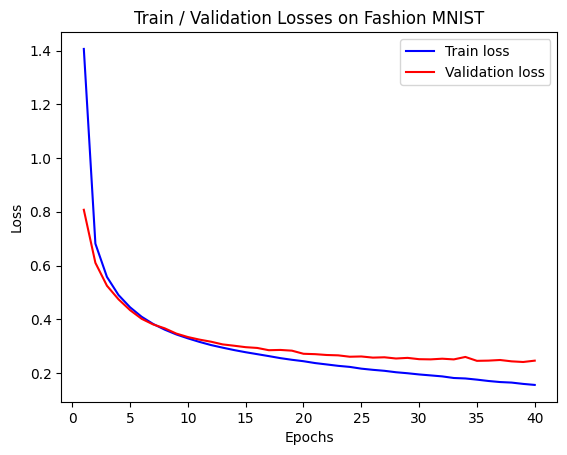

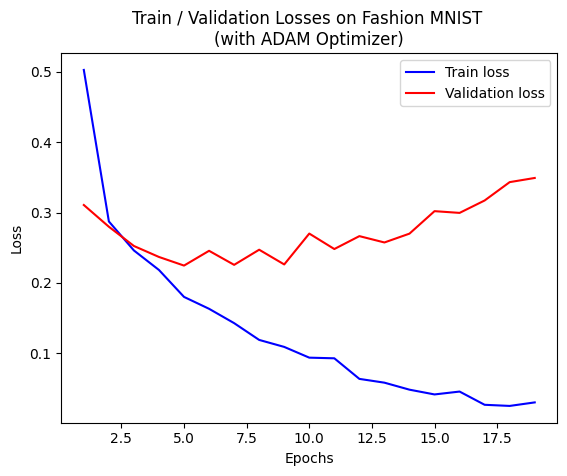

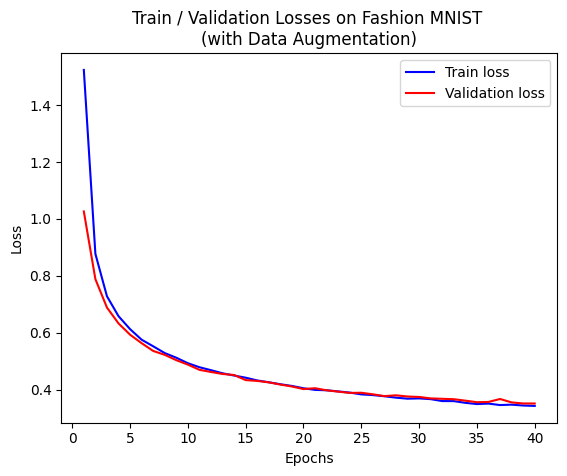

In [17]:
### TODO : Please plot the train/val loss curve ###

import matplotlib.pyplot as plt

def plot_loss(train_loss_epoch, val_loss_epoch, filename, title=''):
    epochs = range(1, len(train_loss_epoch) + 1)
    plt.plot(epochs, train_loss_epoch, label='Train loss', color='b')
    plt.plot(epochs, val_loss_epoch, label='Validation loss', color='r')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()

    plt.savefig(filename)
    plt.show()

plot_loss(results1['train_loss'], results1['val_loss'], f'mnist_result_{config1["name"]}.png', 'Train / Validation Losses on Fashion MNIST')
plot_loss(results2['train_loss'], results2['val_loss'], f'mnist_result_{config2["name"]}.png', 'Train / Validation Losses on Fashion MNIST\n(with ADAM Optimizer)')
plot_loss(results3['train_loss'], results3['val_loss'], f'mnist_result_{config3["name"]}.png', 'Train / Validation Losses on Fashion MNIST\n(with Data Augmentation)')

###########################################################

## Downloading ".onnx file" , and using  Netron to visualize the model


Save the model in .onnx format


In [67]:
!pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 11.4 MB/s eta 0:00:00


[ Train | 001/040 ] loss = 1.57628, acc = 0.55430


100%|██████████| 24/24 [00:02<00:00, 10.81it/s]

[ Valid | 001/040 ] loss = 1.04610, acc = 0.69246
Best model found at epoch 0, saving model


[ Train | 002/040 ] loss = 0.89147, acc = 0.71579


100%|██████████| 24/24 [00:02<00:00,  8.78it/s]

[ Valid | 002/040 ] loss = 0.78552, acc = 0.73344
Best model found at epoch 1, saving model


[ Train | 003/040 ] loss = 0.73998, acc = 0.74004


100%|██████████| 24/24 [00:02<00:00, 11.05it/s]

[ Valid | 003/040 ] loss = 0.69193, acc = 0.75825
Best model found at epoch 2, saving model


[ Train | 004/040 ] loss = 0.66749, acc = 0.75872


100%|██████████| 24/24 [00:02<00:00, 10.89it/s]

[ Valid | 004/040 ] loss = 0.64438, acc = 0.76840
Best model found at epoch 3, saving model


[ Train | 005/040 ] loss = 0.62477, acc = 0.77283


100%|██████████| 24/24 [00:02<00:00, 11.30it/s]

[ Valid | 005/040 ] loss = 0.60353, acc = 0.78085
Best model found at epoch 4, saving model


[ Train | 006/040 ] loss = 0.59111, acc = 0.78286


100%|██████████| 24/24 [00:02<00:00, 11.78it/s]

[ Valid | 006/040 ] loss = 0.57014, acc = 0.79259
Best model found at epoch 5, saving model


[ Train | 007/040 ] loss = 0.56685, acc = 0.79289


100%|██████████| 24/24 [00:02<00:00,  9.85it/s]

[ Valid | 007/040 ] loss = 0.54825, acc = 0.79939
Best model found at epoch 6, saving model


[ Train | 008/040 ] loss = 0.54533, acc = 0.80076


100%|██████████| 24/24 [00:02<00:00,  9.02it/s]

[ Valid | 008/040 ] loss = 0.53546, acc = 0.80341
Best model found at epoch 7, saving model


[ Train | 009/040 ] loss = 0.52630, acc = 0.80826


100%|██████████| 24/24 [00:02<00:00, 10.38it/s]

[ Valid | 009/040 ] loss = 0.51188, acc = 0.81390
Best model found at epoch 8, saving model


[ Train | 010/040 ] loss = 0.51257, acc = 0.81367


100%|██████████| 24/24 [00:02<00:00,  9.74it/s]

[ Valid | 010/040 ] loss = 0.49797, acc = 0.82289
Best model found at epoch 9, saving model


[ Train | 011/040 ] loss = 0.49574, acc = 0.81880


100%|██████████| 24/24 [00:02<00:00,  9.49it/s]

[ Valid | 011/040 ] loss = 0.48562, acc = 0.82404
Best model found at epoch 10, saving model


[ Train | 012/040 ] loss = 0.48152, acc = 0.82292


100%|██████████| 24/24 [00:02<00:00,  9.25it/s]

[ Valid | 012/040 ] loss = 0.47497, acc = 0.82665
Best model found at epoch 11, saving model


[ Train | 013/040 ] loss = 0.47093, acc = 0.82815


100%|██████████| 24/24 [00:02<00:00,  8.53it/s]

[ Valid | 013/040 ] loss = 0.45961, acc = 0.83104
Best model found at epoch 12, saving model


[ Train | 014/040 ] loss = 0.46035, acc = 0.83202


100%|██████████| 24/24 [00:02<00:00,  8.98it/s]

[ Valid | 014/040 ] loss = 0.44798, acc = 0.83684
Best model found at epoch 13, saving model


[ Train | 015/040 ] loss = 0.45234, acc = 0.83668


100%|██████████| 24/24 [00:02<00:00, 10.18it/s]

[ Valid | 015/040 ] loss = 0.44480, acc = 0.84070
Best model found at epoch 14, saving model


[ Train | 016/040 ] loss = 0.44132, acc = 0.84047


100%|██████████| 24/24 [00:02<00:00,  9.96it/s]

[ Valid | 016/040 ] loss = 0.43784, acc = 0.84274
Best model found at epoch 15, saving model


[ Train | 017/040 ] loss = 0.43447, acc = 0.84220


100%|██████████| 24/24 [00:02<00:00, 10.30it/s]

[ Valid | 017/040 ] loss = 0.43459, acc = 0.84210


[ Train | 018/040 ] loss = 0.43177, acc = 0.84277


100%|██████████| 24/24 [00:02<00:00, 10.08it/s]

[ Valid | 018/040 ] loss = 0.42481, acc = 0.84619
Best model found at epoch 17, saving model


[ Train | 019/040 ] loss = 0.42295, acc = 0.84764


100%|██████████| 24/24 [00:02<00:00,  9.47it/s]

[ Valid | 019/040 ] loss = 0.41752, acc = 0.84782
Best model found at epoch 18, saving model


[ Train | 020/040 ] loss = 0.41726, acc = 0.84889


100%|██████████| 24/24 [00:02<00:00,  9.92it/s]

[ Valid | 020/040 ] loss = 0.41204, acc = 0.85318
Best model found at epoch 19, saving model


[ Train | 021/040 ] loss = 0.41037, acc = 0.85171


100%|██████████| 24/24 [00:02<00:00, 11.84it/s]

[ Valid | 021/040 ] loss = 0.40086, acc = 0.85569
Best model found at epoch 20, saving model


[ Train | 022/040 ] loss = 0.40612, acc = 0.85219


100%|██████████| 24/24 [00:02<00:00, 10.20it/s]

[ Valid | 022/040 ] loss = 0.40589, acc = 0.85143


[ Train | 023/040 ] loss = 0.39888, acc = 0.85536


100%|██████████| 24/24 [00:02<00:00, 10.95it/s]

[ Valid | 023/040 ] loss = 0.39532, acc = 0.85671
Best model found at epoch 22, saving model


[ Train | 024/040 ] loss = 0.39505, acc = 0.85645


100%|██████████| 24/24 [00:02<00:00, 11.65it/s]

[ Valid | 024/040 ] loss = 0.39603, acc = 0.85614


[ Train | 025/040 ] loss = 0.39281, acc = 0.85657


100%|██████████| 24/24 [00:02<00:00, 11.54it/s]

[ Valid | 025/040 ] loss = 0.39446, acc = 0.85749
Best model found at epoch 24, saving model


[ Train | 026/040 ] loss = 0.38981, acc = 0.85915


100%|██████████| 24/24 [00:02<00:00,  8.43it/s]

[ Valid | 026/040 ] loss = 0.38393, acc = 0.86267
Best model found at epoch 25, saving model


[ Train | 027/040 ] loss = 0.38180, acc = 0.86034


100%|██████████| 24/24 [00:02<00:00,  9.80it/s]

[ Valid | 027/040 ] loss = 0.38553, acc = 0.85964


[ Train | 028/040 ] loss = 0.38061, acc = 0.86199


100%|██████████| 24/24 [00:02<00:00, 10.24it/s]

[ Valid | 028/040 ] loss = 0.37715, acc = 0.86480
Best model found at epoch 27, saving model


[ Train | 029/040 ] loss = 0.37760, acc = 0.86169


100%|██████████| 24/24 [00:02<00:00, 10.49it/s]

[ Valid | 029/040 ] loss = 0.37851, acc = 0.86390


[ Train | 030/040 ] loss = 0.37082, acc = 0.86467


100%|██████████| 24/24 [00:02<00:00, 10.30it/s]

[ Valid | 030/040 ] loss = 0.37631, acc = 0.85926


[ Train | 031/040 ] loss = 0.36786, acc = 0.86480


100%|██████████| 24/24 [00:02<00:00,  9.72it/s]

[ Valid | 031/040 ] loss = 0.36870, acc = 0.86533
Best model found at epoch 30, saving model


[ Train | 032/040 ] loss = 0.36694, acc = 0.86784


100%|██████████| 24/24 [00:02<00:00,  9.48it/s]

[ Valid | 032/040 ] loss = 0.37072, acc = 0.86570
Best model found at epoch 31, saving model


[ Train | 033/040 ] loss = 0.36468, acc = 0.86792


100%|██████████| 24/24 [00:02<00:00,  9.94it/s]

[ Valid | 033/040 ] loss = 0.37196, acc = 0.86341


[ Train | 034/040 ] loss = 0.36317, acc = 0.86642


100%|██████████| 24/24 [00:02<00:00,  9.24it/s]

[ Valid | 034/040 ] loss = 0.36552, acc = 0.86471


[ Train | 035/040 ] loss = 0.35935, acc = 0.86801


100%|██████████| 24/24 [00:02<00:00,  9.51it/s]

[ Valid | 035/040 ] loss = 0.36230, acc = 0.87027
Best model found at epoch 34, saving model


[ Train | 036/040 ] loss = 0.35728, acc = 0.86882


100%|██████████| 24/24 [00:02<00:00, 10.45it/s]

[ Valid | 036/040 ] loss = 0.35601, acc = 0.87238
Best model found at epoch 35, saving model


[ Train | 037/040 ] loss = 0.35447, acc = 0.87175


100%|██████████| 24/24 [00:02<00:00,  8.32it/s]

[ Valid | 037/040 ] loss = 0.35933, acc = 0.86627


[ Train | 038/040 ] loss = 0.35464, acc = 0.87022


100%|██████████| 24/24 [00:02<00:00, 10.27it/s]

[ Valid | 038/040 ] loss = 0.35774, acc = 0.86498


[ Train | 039/040 ] loss = 0.35020, acc = 0.87174


100%|██████████| 24/24 [00:02<00:00, 10.29it/s]

[ Valid | 039/040 ] loss = 0.35423, acc = 0.86759


[ Train | 040/040 ] loss = 0.34701, acc = 0.87408


100%|██████████| 24/24 [00:02<00:00, 11.05it/s]

[ Valid | 040/040 ] loss = 0.34738, acc = 0.87437
Best model found at epoch 39, saving model
Finished Training


Accuracy of the network on the 20 test images: 88 %


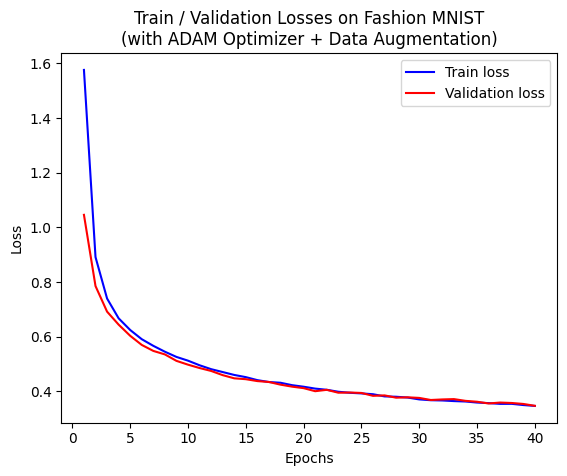

In [18]:
net4 = DNN(in_size=(1, 28, 28), num_classes=10).to(device)
config4 = {
    'name': 'adam_augment',
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optim.SGD(net4.parameters(), lr=0.001, momentum=0.9),
    'batch_size': config1['batch_size'],
    'patience': config1['patience'],
    'n_epoch': config1['n_epoch'],
}

# adam + augment
dataloaders4 = prepare_data(config4, datasets.FashionMNIST, transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),]))

results4 = train_model(net4, config4, dataloaders4, device)
test_model(net4, dataloaders4['test'])
plot_loss(results4['train_loss'], results4['val_loss'], f'mnist_result_{config4["name"]}.png',
        'Train / Validation Losses on Fashion MNIST\n(with ADAM Optimizer + Data Augmentation)')

In [15]:
# Some standard imports
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

### TODO : export your model in .onnx format ###

def export_onnx(net: torch.nn.Module, filename: str):
    net.eval()
    net.cpu()
    x = torch.randn(512, 1, 28, 28)
    torch.onnx.export(net, x, filename, verbose=True)

net1 = DNN(in_size=(1, 28, 28), num_classes=10)
# state_dict = torch.load('./model/basic.pt', map_location=torch.device('cpu'), weights_only=False)
# net1.load_state_dict(state_dict)
export_onnx(net1, './model/fmnist.onnx')

Exported graph: graph(%input.1 : Float(512, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %fc.0.weight : Float(256, 1152, strides=[1152, 1], requires_grad=1, device=cpu),
      %fc.0.bias : Float(256, strides=[1], requires_grad=1, device=cpu),
      %fc.2.weight : Float(10, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc.2.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %onnx::Conv_40 : Float(32, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_41 : Float(32, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_43 : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_44 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %onnx::Conv_46 : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %onnx::Conv_47 : Float(128, strides=[1], requires_grad=0, device=cpu)):
  %/conv1/conv1.0/Conv_output_0 : Float(512, 32, 28, 



*   netron :
  https://netron.app/
  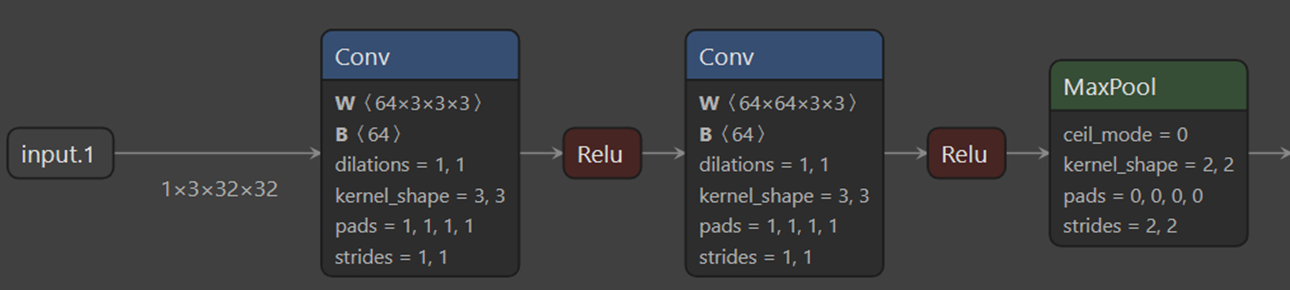